# Modelling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
from sklearn.metrics import roc_curve, auc
import shap
import joblib


In [2]:
# Load our data (cleaning and outlier techniques applied)
df = pd.read_csv('churn_cleaned_df.csv')
df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Contract_Two year,InternetService_DSL,InternetService_Fiber optic,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_outlier,MonthlyCharges_outlier,TotalCharges_outlier
0,7590-VHVEG,0,1,0,1.0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1,5575-GNVDE,0,0,0,34.0,1,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
2,3668-QPYBK,0,0,0,2.0,1,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
3,7795-CFOCW,0,0,0,45.0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0
4,9237-HQITU,0,0,0,2.0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


# Split the dataset
Divide the dataset into training, validation, and test sets. The typical split is 70-80% for training, 10-15% for validation, and 10-15% for testing. The validation set helps in model selection and hyperparameter tuning.

Therefore, in order to obtain a split of 70% for training, 15% for validation, and 15% for testing we are setting the test dataset with a size of 15% of the original dataset, while the combined training/validation set is split with a test size of 0.1765 (approximately 15% of the combined training/validation data).

In [3]:
# Drop the column and save it to a variable
#   If you need to bring the column back later, simply reassign it to the DataFrame
#   df['customerID'] = customer_id
customer_id = df.pop('customerID')

# Separate the target variable (Churn) from the rest of the dataset
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val)


# Balancing our training dataset
Given that our dataset is imbalanced (26.5% of the users churn), we need to correct this effect in order to obtain the desired results with the model.

SMOTE (Synthetic Minority Over-sampling Technique) is a popular algorithm used for data upsampling in machine learning. It creates synthetic samples of the minority class by creating new observations that are similar to existing observations, thus balancing the class distribution. We can perform data upsampling using SMOTE in Python with the imbalanced-learn library.

Balancing your dataset with SMOTE should be performed on the training set only. This way, you ensure that your model learns from a balanced representation of the data while preserving the integrity and independence of the test and validation datasets. In other words, you avoid information leakage, realistic representation of the data and an independent evaluation of the model.

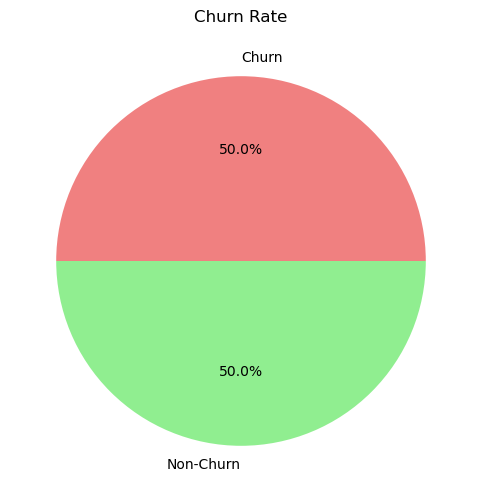

In [4]:
# Instantiate the SMOTE object
oversample = SMOTE()

# Apply SMOTE to upsample the minority class (Churn = 1) on the training set only
X_resampled_train, y_resampled_train = oversample.fit_resample(X_train, y_train)


####### IS THIS CORRECT??????????????????????
# Combine the resampled features and target variable into a new training DataFrame
resampled_df_train = pd.concat([X_resampled_train, y_resampled_train], axis=1)

# Calculate the churn and non-churn counts
churn_count = resampled_df_train[resampled_df_train['Churn'] == 1].SeniorCitizen.count()
non_churn_count = resampled_df_train[resampled_df_train['Churn'] == 0].SeniorCitizen.count()

# Set up the plot size and title
plt.figure(figsize=(8, 6))
plt.title('Churn Rate')

# Set the colors for the pie chart sections
colors = ['lightcoral', 'lightgreen']

# Create the pie chart
plt.pie([churn_count, non_churn_count], labels=['Churn', 'Non-Churn'], autopct='%1.1f%%', colors=colors)

# Display the plot
plt.show()

# Model selection
We are exploring different options for our churn prediction, from more simple and interpretable models (i.e. Logistic Regression) to advanced models (i.e. SVM or XGBoost). We will decide which one to pick based on the validation set's performance metrics.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Define a list of models including additional choices
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(probability=True),
    XGBClassifier(),
    MLPClassifier(max_iter=1000)
]

# Iterate over the models
for model in models:
    # Train the model on the resampled training set
    model.fit(X_resampled_train, y_resampled_train)

    # Make predictions on the validation set
    y_pred_val = model.predict(X_val)

    # Calculate prediction probabilities on the validation set
    y_prob_val = model.predict_proba(X_val)[:, 1] # Probability of the positive class (churn)

    # Evaluate the model performance on the validation set
    accuracy_val = accuracy_score(y_val, y_pred_val)
    recall_val = recall_score(y_val, y_pred_val)
    precision_val = precision_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val)
    cm_val = confusion_matrix(y_val, y_pred_val)
    tn_val, fp_val, fn_val, tp_val = cm_val.ravel()
    specificity_val = tn_val / (tn_val + fp_val)

    # Print evaluation metrics on the validation set for each model
    print(f"Model: {type(model).__name__}")
    print("Validation classification report")
    print(f"Accuracy: {accuracy_val:.4f}")
    print(f"Recall: {recall_val:.4f}")
    print(f"Precision: {precision_val:.4f}")
    print(f"F1 Score: {f1_val:.4f}")
    print(f"Confusion Matrix: \n{cm_val}")
    print(f"Specificity: {specificity_val:.4f}")
    print("\n")

Model: LogisticRegression
Validation classification report
Accuracy: 0.7900
Recall: 0.6085
Precision: 0.6042
F1 Score: 0.6064
Confusion Matrix: 
[[664 112]
 [110 171]]
Specificity: 0.8557


Model: DecisionTreeClassifier
Validation classification report
Accuracy: 0.7058
Recall: 0.4875
Precision: 0.4507
F1 Score: 0.4684
Confusion Matrix: 
[[609 167]
 [144 137]]
Specificity: 0.7848


Model: RandomForestClassifier
Validation classification report
Accuracy: 0.7748
Recall: 0.5516
Precision: 0.5805
F1 Score: 0.5657
Confusion Matrix: 
[[664 112]
 [126 155]]
Specificity: 0.8557


Model: SVC
Validation classification report
Accuracy: 0.6746
Recall: 0.5872
Precision: 0.4198
F1 Score: 0.4896
Confusion Matrix: 
[[548 228]
 [116 165]]
Specificity: 0.7062


Model: XGBClassifier
Validation classification report
Accuracy: 0.7739
Recall: 0.5445
Precision: 0.5795
F1 Score: 0.5615
Confusion Matrix: 
[[665 111]
 [128 153]]
Specificity: 0.8570


Model: MLPClassifier
Validation classification report
Accuracy

Given that Logistic Regression and MLPClassifier offer similar metrics (i.e. F-1 score of 0.60), we need to analyse how to proceed forward given the nature of each model. In short, MLPClassifier models can offer better predictive performance and have the ability to capture complex nonlinear relationships in the data. However, Logistic Regression models are typically considered easier to use and deploy in production compared to MLPClassifier (multi-layer perceptron) models We will continue with Logistic Regression due to:

- Simplicity and interpretability: Logistic regression models have a simpler structure and are more interpretable than MLPClassifier models. The coefficients in logistic regression directly represent the impact of each feature on the target variable, making it easier to understand and communicate the model's behavior.

- Lower computational requirements: Logistic regression models are computationally less demanding compared to MLPClassifier models, especially for large datasets or complex architectures. They have fewer parameters to tune and generally require less computational power for training and inference.

- Faster inference: Logistic regression models typically have faster inference times compared to MLPClassifier models, especially when the MLPClassifier has a large number of hidden layers and neurons. Logistic regression calculates a simple linear combination of features, while MLPClassifier involves complex computations in multiple layers.

- Deployment considerations: Logistic regression models can be easily implemented using standard statistical libraries and frameworks. They have straightforward implementation requirements, and their integration into production systems is relatively simpler compared to neural network models like MLPClassifier.

# Hyperparameter tuning
Fine-tune the hyperparameters of the selected model to optimize its performance. Use techniques like grid search, random search, or Bayesian optimization. Take care not to overfit the validation set during this process.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [5000]  # Increase the maximum number of iterations
}

# Create the Logistic Regression model
model = LogisticRegression()

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5)
grid_search.fit(X_resampled_train, y_resampled_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Make predictions on the validation set using the best model
y_pred_val = best_model.predict(X_val)

# Calculate evaluation metrics on the validation set
accuracy_val = accuracy_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
cm_val = confusion_matrix(y_val, y_pred_val)
tn_val, fp_val, fn_val, tp_val = cm_val.ravel()
specificity_val = tn_val / (tn_val + fp_val)

# Print evaluation metrics on the validation set
print("Validation classification report")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")
print(f"Confusion Matrix: \n{cm_val}")
print(f"Specificity: {specificity_val:.4f}")


Best Hyperparameters:
C: 0.1
max_iter: 5000
penalty: l1
solver: liblinear
Validation classification report
Accuracy: 0.7833
Recall: 0.6335
Precision: 0.5855
F1 Score: 0.6085
Confusion Matrix: 
[[650 126]
 [103 178]]
Specificity: 0.8376


# Testing our tuned model

In [7]:
best_params = {
    'penalty': 'l2',
    'C': 10,
    'solver': 'liblinear',
    'max_iter': 5000
}

# Initialize LogisticRegression classifier
model = LogisticRegression(**best_params)

# Train the model on the resampled training set
model.fit(X_resampled_train, y_resampled_train)

 # Make predictions on the test set
y_pred_test = model.predict(X_test)

# Calculate prediction probabilities on the test set
y_prob_test = model.predict_proba(X_test)[:, 1] # Probability of the positive class (churn)

# Evaluate the model performance on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
specificity_test = tn_test / (tn_test + fp_test)

# Print evaluation metrics on the test set
print("\nTest classification report")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"Confusion Matrix: \n{cm_test}")
print(f"Specificity: {specificity_test:.4f}")


Test classification report
Accuracy: 0.7815
Recall: 0.6250
Precision: 0.5814
F1 Score: 0.6024
Confusion Matrix: 
[[651 126]
 [105 175]]
Specificity: 0.8378


# Model interpretability
Model interpretability is important for building trust between stakeholders, understanding model behavior, identifying and resolving errors, ensuring regulatory compliance, facilitating collaboration, and guiding model improvement. It plays a critical role in the practical application of machine learning models and enables their effective and responsible use in real-world scenarios.

Permutation explainer: 1058it [00:12, 17.94it/s]                          


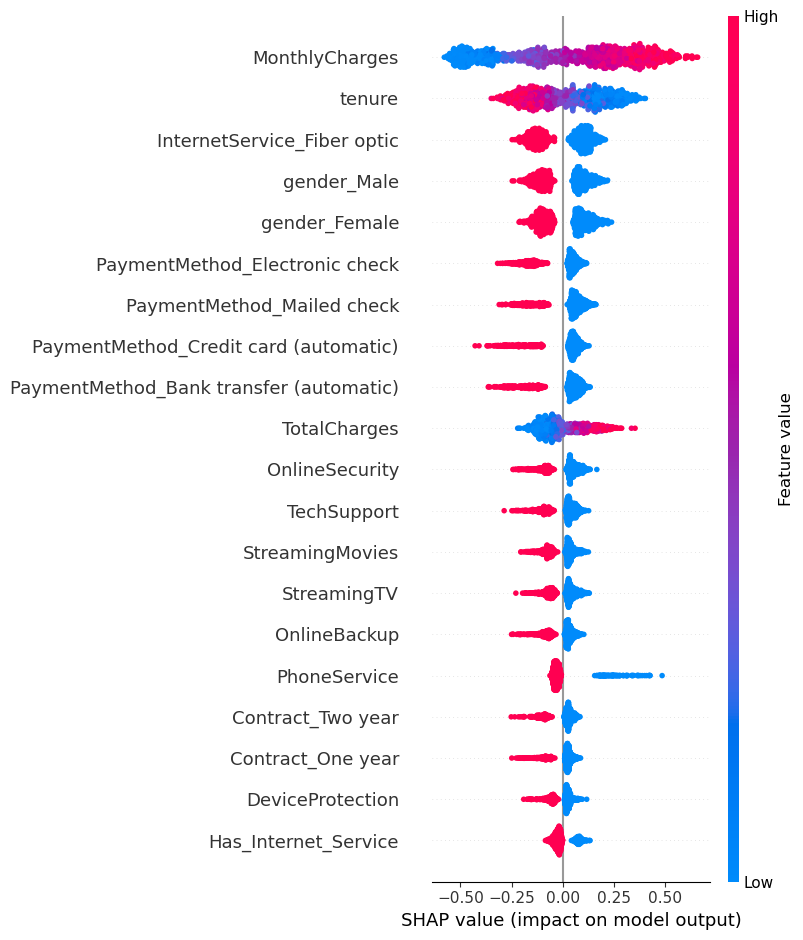

In [8]:
# Create SHAP values for the test set
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

# Create a summary plot
shap.summary_plot(shap_values, X_test)

MonthlyCharges being blue on the left and red on the right, it means that low values of MonthlyCharges have a negative impact on the predicted target value (i.e., lower probability of churn), whereas high values of MonthlyCharges have a positive impact (i.e., higher probability of churn).

Similarly, with tenure being blue on the right and red on the left, it means that low values of tenure have a positive impact on the predicted target value (i.e., higher probability of churn), whereas high values of tenure have a negative impact (i.e., lower probability of churn).

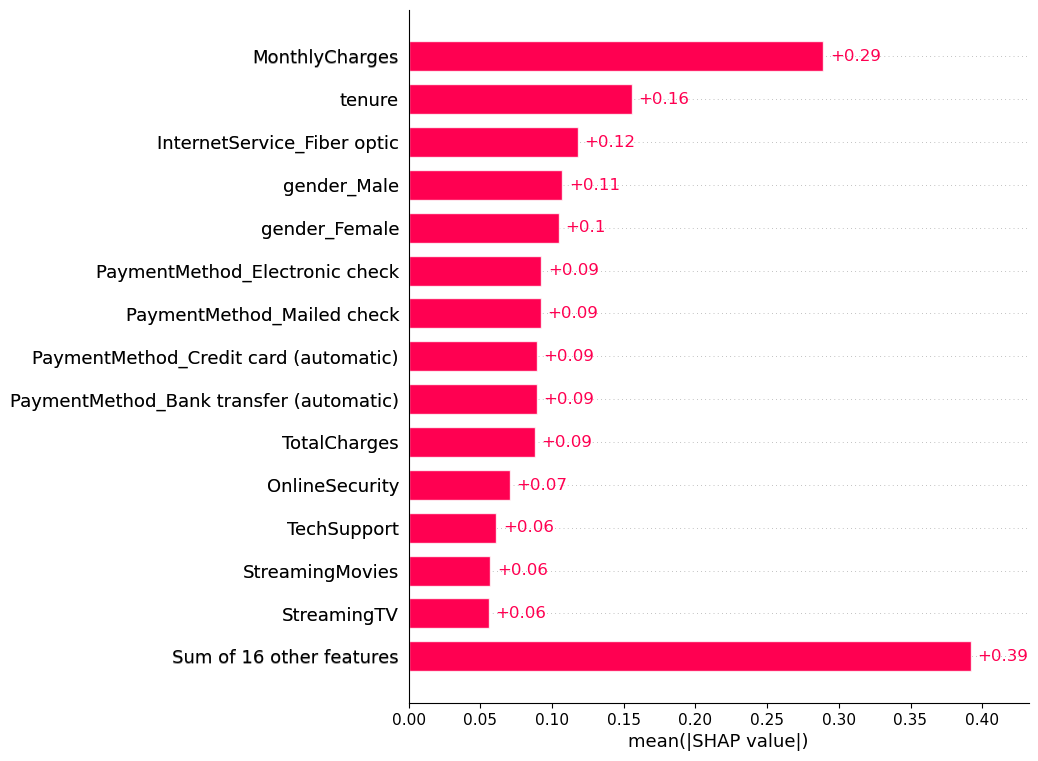

In [9]:
shap.plots.bar(shap_values, max_display=15)

In this case, the output shows that Contract_Two year is the most important feature, with a SHAP value of +0.16%. This means that changes in the Contract_Two year feature have the largest impact on the model's predictions. Specifically, This indicates that customers who are on a two-year contract are less likely to churn compared to those on a one-year or month-to-month contract.

The MonthlyCharges feature is the second most important feature with a SHAP value of +0.16% too. An increase in MonthlyCharges is associated with an increase in the likelihood of churn, while an decrease in MonthlyCharges is associated with a decrease in the likelihood of churn.

Overall, these results suggest that pricing plans, contract terms and how long are customers engaged with the company (tenure) are important factors in predicting customer churn. The model may be used to optimize pricing plans and contract terms to minimize churn and maximize customer retention.

In [10]:
# Forceplot for first observation
shap.initjs()
shap.plots.force(shap_values[38]) 

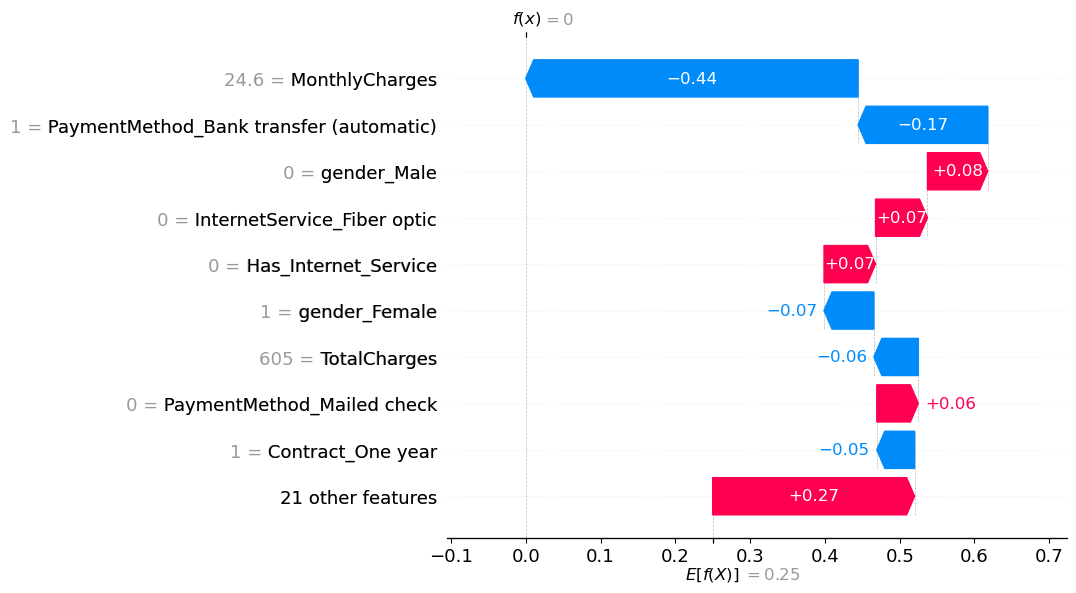

In [11]:
# Plot the SHAP values
shap.plots.waterfall(shap_values[38])

# Storing the trained model
Storing the model locally provides convenience, reproducibility, deployment flexibility, and collaboration capabilities. It allows you to leverage the trained model for making predictions, sharing, and working on further improvements without the need for retraining or relying on the original training data.

We will be using `joblib`, a Python library that provides tools for efficient and easy serialization (saving) and deserialization (loading) of Python objects. It is primarily used for handling large data structures, such as NumPy arrays or scikit-learn models, in a way that minimizes memory usage and serialization time. It provides improved efficiency, memory management, and parallel processing capabilities compared to the standard pickle module.

In [12]:
# Save the trained model to a file
filename = 'churn_prediction_logreg_model.joblib'
joblib.dump(model, filename)

['churn_prediction_logreg_model.joblib']

In [13]:
# Load the saved model from file
loaded_model = joblib.load(filename)

# Read one row of data for demonstration purposes
X_new = pd.read_csv('churn_cleaned_df.csv').tail(1)
X_new = X_new.drop(['Churn', 'customerID'], axis=1)

# Use the loaded model for predictions
y_pred = loaded_model.predict(X_new)

# Print results
y_pred

array([0])